In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers.experimental import RandomFourierFeatures
import tensorflow_addons as tfa
import tensorflowjs as tfjs
import matplotlib.pyplot as plt

from sklearn.svm import SVR
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score

print('\u2022 Using TensorFlow Version: ', tf.__version__)
print('\u2022 Using TensorFlow Version: ', tfa.__version__)

• Using TensorFlow Version:  2.8.0
• Using TensorFlow Version:  0.16.1


In [2]:
# Folders & Paths
audio_path = './audio/'

features_path = './features/Normalized_Features.csv'

truth_path = './truth/ratings/'
aro_truth_path = truth_path + 'Arousal.csv'
val_truth_path = truth_path + 'Valence.csv'

In [3]:
features_norm = pd.read_csv(features_path)
aro_truth = pd.read_csv(aro_truth_path, header=None)
val_truth = pd.read_csv(val_truth_path, header=None)

In [4]:
# Normalized features statistics
features_norm

,fileName,rms_mean,rms_std,decreaseslope_mean,fluctuation_max,eventdensity_mean,zerocross_mean,zerocross_std,rolloff_mean,rolloff_std,...,loudness_mean,loudness_std,energy_mean,energy_std,perceptual_sharp_mean,perceptual_sharp_std,spectral_slope_mean,spectral_slope_std,spectral_var_mean,spectral_var_std
0,mix_between_human_indicator_1-12_1-6.wav,0.057916,0.181649,0.206975,0.078080,0.180149,0.080720,0.321308,0.128489,0.121556,...,0.191118,0.347576,0.058354,0.181010,0.176589,0.352935,0.114804,0.356061,0.496309,0.199965
1,mix_between_human_indicator_1-6_1-12.wav,0.029380,0.090423,0.196134,0.070676,0.180149,0.078890,0.315966,0.156579,0.222034,...,0.139904,0.240593,0.029598,0.090092,0.204845,0.335579,0.132931,0.344697,0.508387,0.214740
2,mix_between_human_indicator_1-6_1-6.wav,0.058108,0.181268,0.206228,0.076273,0.180149,0.079321,0.308780,0.140393,0.199835,...,0.193484,0.344449,0.058544,0.180633,0.184976,0.337910,0.116314,0.344697,0.500550,0.196160
3,mix_between_human_indicator_2-12_2-6.wav,0.034239,0.044759,0.261880,0.083218,0.340900,0.160497,0.287264,0.292328,0.114858,...,0.199732,0.199390,0.034204,0.045013,0.315799,0.262805,0.212991,0.295455,0.539779,0.173066
4,mix_between_human_indicator_2-6_2-12.wav,0.064380,0.076265,0.260347,0.087722,0.843000,0.168180,0.278942,0.297361,0.113448,...,0.272825,0.277877,0.064285,0.076973,0.322426,0.252839,0.217523,0.291667,0.540959,0.129461
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1208,r_5indicator59071_8556-hq.wav,0.106141,0.046720,0.107604,0.043783,1.000000,0.206274,0.211808,0.564615,0.171320,...,0.374871,0.258196,0.106127,0.048706,0.383245,0.122873,0.326284,0.163258,0.296059,0.119320
1209,r_6mechanical60455_27178-hq.wav,0.077711,0.046950,0.123511,0.035052,1.000000,0.112818,0.250360,0.286410,0.432750,...,0.267722,0.311533,0.077776,0.047545,0.245375,0.201658,0.160121,0.242424,0.453177,0.157346
1210,r_6mechanical66618_800302-hq.wav,0.339912,0.174158,0.557340,0.047963,1.000000,0.045219,0.187232,0.152356,0.053483,...,0.497385,0.659042,0.339674,0.181340,0.190987,0.162281,0.096677,0.193182,0.402072,0.188584
1211,r_7mechanical54899_170972-hq.wav,0.136810,0.058775,0.110323,0.037463,1.000000,0.078109,0.175816,0.172034,0.052256,...,0.378655,0.404539,0.136725,0.062171,0.202077,0.161894,0.117825,0.192803,0.371038,0.110928


In [5]:
# Arousal ground truth ratings
aro_truth

,0,1
0,mix_between_human_indicator_1-12_1-6.wav,0.523495
1,mix_between_human_indicator_1-6_1-12.wav,0.211871
2,mix_between_human_indicator_1-6_1-6.wav,0.589448
3,mix_between_human_indicator_2-12_2-6.wav,0.396538
4,mix_between_human_indicator_2-6_2-12.wav,0.764221
...,...,...
1208,r_5indicator59071_8556-hq.wav,0.902721
1209,r_6mechanical60455_27178-hq.wav,0.655400
1210,r_6mechanical66618_800302-hq.wav,0.968673
1211,r_7mechanical54899_170972-hq.wav,0.812036


In [6]:
aro_y = aro_truth[1].astype(np.float32)
aro_y

0       0.523495
1       0.211871
2       0.589448
3       0.396538
4       0.764221
          ...   
1208    0.902721
1209    0.655400
1210    0.968673
1211    0.812036
1212    0.927453
Name: 1, Length: 1213, dtype: float32

In [7]:
# Valence ground truth ratings
val_truth

,0,1
0,mix_between_human_indicator_1-12_1-6.wav,-0.767519
1,mix_between_human_indicator_1-6_1-12.wav,-0.577906
2,mix_between_human_indicator_1-6_1-6.wav,-0.752679
3,mix_between_human_indicator_2-12_2-6.wav,0.526793
4,mix_between_human_indicator_2-6_2-12.wav,-0.190437
...,...,...
1208,r_5indicator59071_8556-hq.wav,-0.952185
1209,r_6mechanical60455_27178-hq.wav,-0.742786
1210,r_6mechanical66618_800302-hq.wav,-0.965375
1211,r_7mechanical54899_170972-hq.wav,0.022259


In [8]:
val_y = val_truth[1].astype(np.float32)
val_y

0      -0.767519
1      -0.577906
2      -0.752679
3       0.526793
4      -0.190437
          ...   
1208   -0.952185
1209   -0.742786
1210   -0.965375
1211    0.022259
1212   -0.592745
Name: 1, Length: 1213, dtype: float32

In [9]:
files_list = features_norm['fileName'].tolist()
print(f'Number of files: {len(files_list)}')

Number of files: 1213


In [10]:
# Meyda extractable features
features = ['rms','zerocross','rolloff','centroid','spread','skewness','kurtosis','flatness','mfcc','chromagram','loudness','energy','perceptual_sharp','spectral_slope']
# meyda_available_features = ['rms','zcr','spectralRolloff','spectralCentroid','spectralSpread','spectralSkewness','spectralKurtosis','spectralFlatness','mfcc','chroma','loudness','energy','perceptualSharpness','spectralSlope']

print(f'Number of features: {len(features)}')

Number of features: 14


In [11]:
# Create list of usable features
mean_str = 'mean'
std_str = 'std'
num_mfcc = 13
num_chroma = 12

chroma_list = []
mfcc_list = []
features_list = [None] * len(features) * 2

mfcc_idx = features.index('mfcc') * 2
chroma_idx = features.index('chromagram') * 2


for i in range(num_chroma):
    chroma_str = f'chromagram_{mean_str}_{str(i+1)}'
    chroma_list.append(chroma_str)

for i in range(num_chroma):
    chroma_str = f'chromagram_{std_str}_{str(i+1)}'
    chroma_list.append(chroma_str)


for i in range(num_mfcc):
    mfcc_str = f'mfcc_{mean_str}_{str(i+1)}'
    mfcc_list.append(mfcc_str)

for i in range(num_mfcc):
    mfcc_str = f'mfcc_{std_str}_{str(i+1)}'
    mfcc_list.append(mfcc_str)

mean_list = [f'{feature}_{mean_str}' for feature in features]
std_list = [f'{feature}_{std_str}' for feature in features]

features_list[::2] = mean_list
features_list[1::2] = std_list

features_list.pop(chroma_idx + 1)
features_list.pop(chroma_idx)
features_list[chroma_idx:chroma_idx] = chroma_list
features_list.pop(mfcc_idx + 1)
features_list.pop(mfcc_idx)
features_list[mfcc_idx:mfcc_idx] = mfcc_list

print(len(features_list))
features_list

74


['rms_mean',
 'rms_std',
 'zerocross_mean',
 'zerocross_std',
 'rolloff_mean',
 'rolloff_std',
 'centroid_mean',
 'centroid_std',
 'spread_mean',
 'spread_std',
 'skewness_mean',
 'skewness_std',
 'kurtosis_mean',
 'kurtosis_std',
 'flatness_mean',
 'flatness_std',
 'mfcc_mean_1',
 'mfcc_mean_2',
 'mfcc_mean_3',
 'mfcc_mean_4',
 'mfcc_mean_5',
 'mfcc_mean_6',
 'mfcc_mean_7',
 'mfcc_mean_8',
 'mfcc_mean_9',
 'mfcc_mean_10',
 'mfcc_mean_11',
 'mfcc_mean_12',
 'mfcc_mean_13',
 'mfcc_std_1',
 'mfcc_std_2',
 'mfcc_std_3',
 'mfcc_std_4',
 'mfcc_std_5',
 'mfcc_std_6',
 'mfcc_std_7',
 'mfcc_std_8',
 'mfcc_std_9',
 'mfcc_std_10',
 'mfcc_std_11',
 'mfcc_std_12',
 'mfcc_std_13',
 'chromagram_mean_1',
 'chromagram_mean_2',
 'chromagram_mean_3',
 'chromagram_mean_4',
 'chromagram_mean_5',
 'chromagram_mean_6',
 'chromagram_mean_7',
 'chromagram_mean_8',
 'chromagram_mean_9',
 'chromagram_mean_10',
 'chromagram_mean_11',
 'chromagram_mean_12',
 'chromagram_std_1',
 'chromagram_std_2',
 'chromagram_s

In [12]:
# filter data to accomodate available features
f_features_norm = features_norm.filter(features_list).astype(np.float32)
print(f_features_norm.dtypes)
f_features_norm

rms_mean                 float32
rms_std                  float32
zerocross_mean           float32
zerocross_std            float32
rolloff_mean             float32
                          ...   
energy_std               float32
perceptual_sharp_mean    float32
perceptual_sharp_std     float32
spectral_slope_mean      float32
spectral_slope_std       float32
Length: 74, dtype: object


,rms_mean,rms_std,zerocross_mean,zerocross_std,rolloff_mean,rolloff_std,centroid_mean,centroid_std,spread_mean,spread_std,...,chromagram_std_11,chromagram_std_12,loudness_mean,loudness_std,energy_mean,energy_std,perceptual_sharp_mean,perceptual_sharp_std,spectral_slope_mean,spectral_slope_std
0,0.057916,0.181649,0.080720,0.321308,0.128489,0.121556,0.075689,0.069339,0.115824,0.195989,...,0.486863,0.449088,0.191118,0.347576,0.058354,0.181010,0.176589,0.352935,0.114804,0.356061
1,0.029380,0.090423,0.078890,0.315966,0.156579,0.222034,0.101282,0.133305,0.223017,0.419552,...,0.488677,0.445115,0.139904,0.240593,0.029598,0.090092,0.204845,0.335579,0.132931,0.344697
2,0.058108,0.181268,0.079321,0.308780,0.140393,0.199835,0.083232,0.115822,0.132058,0.246303,...,0.486936,0.446409,0.193484,0.344449,0.058544,0.180633,0.184976,0.337910,0.116314,0.344697
3,0.034239,0.044759,0.160497,0.287264,0.292328,0.114858,0.195098,0.063163,0.243513,0.084057,...,0.425687,0.386710,0.199732,0.199390,0.034204,0.045013,0.315799,0.262805,0.212991,0.295455
4,0.064380,0.076265,0.168180,0.278942,0.297361,0.113448,0.200090,0.058414,0.231721,0.084002,...,0.430076,0.384531,0.272825,0.277877,0.064285,0.076973,0.322426,0.252839,0.217523,0.291667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1208,0.106141,0.046720,0.206274,0.211808,0.564615,0.171320,0.348198,0.204170,0.527218,0.134059,...,0.667863,0.572254,0.374871,0.258196,0.106127,0.048706,0.383245,0.122873,0.326284,0.163258
1209,0.077711,0.046950,0.112818,0.250360,0.286410,0.432750,0.154018,0.289175,0.288548,0.495799,...,0.357107,0.415765,0.267722,0.311533,0.077776,0.047545,0.245375,0.201658,0.160121,0.242424
1210,0.339912,0.174158,0.045219,0.187232,0.152356,0.053483,0.083377,0.022200,0.147617,0.060942,...,0.464942,0.432722,0.497385,0.659042,0.339674,0.181340,0.190987,0.162281,0.096677,0.193182
1211,0.136810,0.058775,0.078109,0.175816,0.172034,0.052256,0.104899,0.037419,0.115945,0.041124,...,0.472617,0.411407,0.378655,0.404539,0.136725,0.062171,0.202077,0.161894,0.117825,0.192803


# Support Vector Regression Baseline Model

In [13]:
all_features_norm = features_norm.copy().drop('fileName',axis=1).astype(np.float32)
all_features_norm

,rms_mean,rms_std,decreaseslope_mean,fluctuation_max,eventdensity_mean,zerocross_mean,zerocross_std,rolloff_mean,rolloff_std,brightness_mean,...,loudness_mean,loudness_std,energy_mean,energy_std,perceptual_sharp_mean,perceptual_sharp_std,spectral_slope_mean,spectral_slope_std,spectral_var_mean,spectral_var_std
0,0.057916,0.181649,0.206975,0.078080,0.180149,0.080720,0.321308,0.128489,0.121556,0.256286,...,0.191118,0.347576,0.058354,0.181010,0.176589,0.352935,0.114804,0.356061,0.496309,0.199965
1,0.029380,0.090423,0.196134,0.070676,0.180149,0.078890,0.315966,0.156579,0.222034,0.271329,...,0.139904,0.240593,0.029598,0.090092,0.204845,0.335579,0.132931,0.344697,0.508387,0.214740
2,0.058108,0.181268,0.206228,0.076273,0.180149,0.079321,0.308780,0.140393,0.199835,0.260993,...,0.193484,0.344449,0.058544,0.180633,0.184976,0.337910,0.116314,0.344697,0.500550,0.196160
3,0.034239,0.044759,0.261880,0.083218,0.340900,0.160497,0.287264,0.292328,0.114858,0.558156,...,0.199732,0.199390,0.034204,0.045013,0.315799,0.262805,0.212991,0.295455,0.539779,0.173066
4,0.064380,0.076265,0.260347,0.087722,0.843000,0.168180,0.278942,0.297361,0.113448,0.576993,...,0.272825,0.277877,0.064285,0.076973,0.322426,0.252839,0.217523,0.291667,0.540959,0.129461
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1208,0.106141,0.046720,0.107604,0.043783,1.000000,0.206274,0.211808,0.564615,0.171320,0.588964,...,0.374871,0.258196,0.106127,0.048706,0.383245,0.122873,0.326284,0.163258,0.296059,0.119320
1209,0.077711,0.046950,0.123511,0.035052,1.000000,0.112818,0.250360,0.286410,0.432750,0.332642,...,0.267722,0.311533,0.077776,0.047545,0.245375,0.201658,0.160121,0.242424,0.453177,0.157346
1210,0.339912,0.174158,0.557341,0.047963,1.000000,0.045219,0.187232,0.152356,0.053483,0.259379,...,0.497385,0.659042,0.339674,0.181340,0.190987,0.162281,0.096677,0.193182,0.402072,0.188584
1211,0.136810,0.058775,0.110323,0.037463,1.000000,0.078109,0.175816,0.172034,0.052256,0.385884,...,0.378655,0.404539,0.136725,0.062171,0.202077,0.161894,0.117825,0.192803,0.371038,0.110928


In [14]:
# split data into train and test 9:1 for Arousal

kfold = KFold(n_splits=10, shuffle=True)
mse = np.empty((1,0),dtype=float)
r2 = np.empty((1,0),dtype=float)
for train_index, test_index in kfold.split(all_features_norm):
    train_X, test_X = all_features_norm.iloc[train_index, :], all_features_norm.iloc[test_index, :]
    train_Y, test_Y = aro_y[train_index], aro_y[test_index]

    reg = make_pipeline(SVR(kernel='rbf', gamma='auto'))
    reg.fit(train_X, train_Y)

    pred = reg.predict(test_X)
    mse = np.append(mse, mean_squared_error(test_Y, pred))
    r2 = np.append(r2,r2_score(test_Y, pred))

print('Arousal - 10 fold cross validation')
print('r2:')
print(r2)
print('MSE:')
print(mse)

aro_data = {
    'Mean': [
        np.mean(r2),
        np.mean(mse)
    ],
    'Std': [
        np.std(r2),
        np.std(mse)
    ]}
index = ['r2', 'MSE']

aro_df = pd.DataFrame(data=aro_data, index=index)
aro_df

Arousal - 10 fold cross validation
r2:
[0.81573141 0.75441118 0.80490381 0.83386745 0.84318671 0.7499544
 0.7694012  0.81525508 0.77523311 0.77517342]
MSE:
[0.05708745 0.07520305 0.0583616  0.06001713 0.05486512 0.08394502
 0.0717186  0.0672347  0.06647909 0.07793994]


,Mean,Std
r2,0.793712,0.031416
MSE,0.067285,0.009299


In [15]:
# split data into train and test 9:1 for Valance

kfold = KFold(n_splits=10, shuffle=True)
mse = np.empty((1,0),dtype=float)
r2 = np.empty((1,0),dtype=float)
for train_index, test_index in kfold.split(all_features_norm):
    train_X, test_X = all_features_norm.iloc[train_index, :], all_features_norm.iloc[test_index, :]
    train_Y, test_Y = val_y[train_index], val_y[test_index]

    reg = make_pipeline(SVR(kernel='rbf', gamma='auto'))
    reg.fit(train_X, train_Y)

    pred = reg.predict(test_X)
    mse = np.append(mse, mean_squared_error(test_Y, pred))
    r2 = np.append(r2,r2_score(test_Y, pred))

print('Valance - 10 fold cross validation')
print('r2:')
print(r2)
print('MSE:')
print(mse)

val_data = {
    'Mean': [
        np.mean(r2),
        np.mean(mse)
    ],
    'Std': [
        np.std(r2),
        np.std(mse)
    ]}
index = ['r2', 'MSE']

val_df = pd.DataFrame(data=val_data, index=index)
val_df

Valance - 10 fold cross validation
r2:
[0.61088377 0.60018638 0.56163316 0.46159772 0.57098077 0.617035
 0.54270048 0.51850338 0.61494057 0.52700861]
MSE:
[0.14375515 0.12826027 0.13997943 0.1788558  0.15120166 0.12293315
 0.13811416 0.14643341 0.14104119 0.14257247]


,Mean,Std
r2,0.562547,0.048298
MSE,0.143315,0.014217


### SVR Baseline Metrics

In [16]:
df = pd.concat([aro_df,val_df], axis=1)
df.index = pd.Index(['R square', 'Mean Square Error'])
df.columns = pd.MultiIndex.from_product([['Arousal', 'Valance'],['Mean', 'Std']])

s = df.style
s.set_table_styles([
    {'selector': 'th.col_heading', 'props': 'text-align: center; font-size: 1.2em; font-style: italic; padding: 0 3em;'},
    {'selector': 'th.col_heading.level0', 'props': 'font-style: normal; font-size: 1.5em;'},
    {'selector': 'th.row_heading', 'props': 'text-align: center; font-size: 1.2em; font-style: italic; font-weight: bold;'},
    {'selector': 'td', 'props': 'text-align: center;'},
], overwrite=False)

# Neural Net Baseline Model

KFold Split: 1
KFold Split: 2
KFold Split: 3
KFold Split: 4
KFold Split: 5
KFold Split: 6
KFold Split: 7
KFold Split: 8
KFold Split: 9
KFold Split: 10
Arousal - 10 fold cross validation
r2:
[0.79999381 0.84611666 0.80006604 0.87250454 0.89079326 0.84823627
 0.82088652 0.82184211 0.0023064  0.66301542]
MSE:
[0.04924814 0.04279658 0.04283566 0.03259261 0.02752992 0.06006974
 0.07283065 0.0612637  0.13440681 0.1087968 ]


,Mean,Std
r2,0.736576,0.251738
MSE,0.063237,0.032389


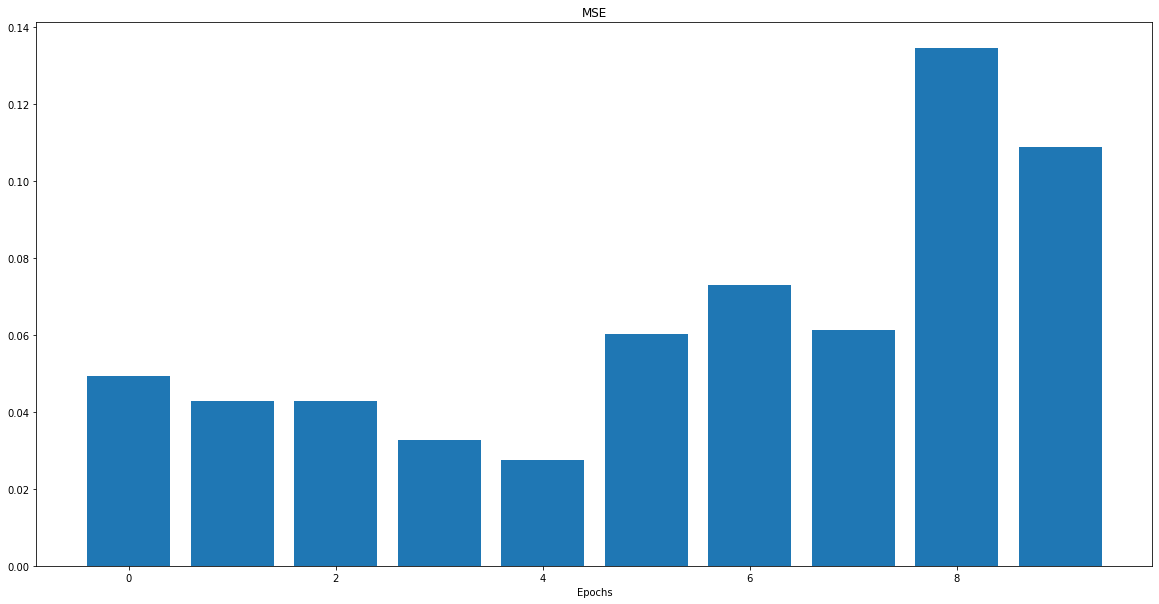

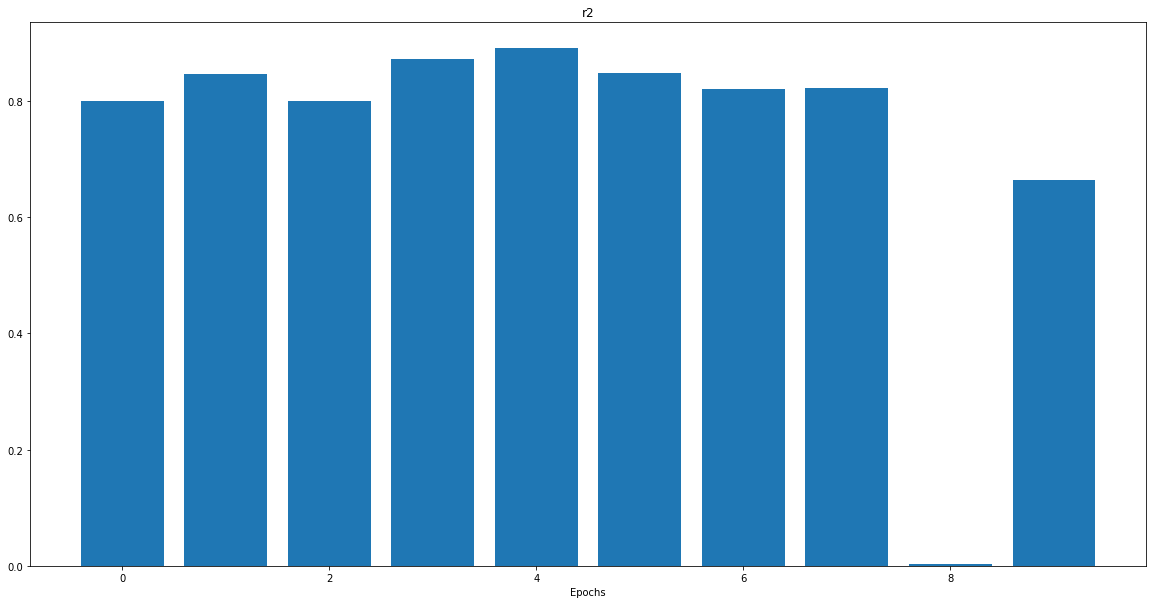

In [32]:
# Arousal Neural Net
kfold = KFold(n_splits=10)
k = 0
r2 = np.empty((1,0),dtype=float)
mse = np.empty((1,0),dtype=float)

for train_index, test_index in kfold.split(all_features_norm):
    k += 1
    print(f'KFold Split: {k}')
    train_X, test_X = all_features_norm.iloc[train_index, :], all_features_norm.iloc[test_index, :]
    train_Y, test_Y = aro_y[train_index], aro_y[test_index]

    train_dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y))
    test_dataset = tf.data.Dataset.from_tensor_slices((test_X, test_Y))
    SHUFFLE_BUFFER_SIZE = 121

    BATCH_SIZE = 1
    train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
    test_dataset = test_dataset.batch(BATCH_SIZE)

    aro_model = keras.Sequential([
        keras.layers.Dense(50, activation='relu'),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(20, activation='relu'),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(1, activation='linear')
    ])

    aro_model.compile(
        optimizer=keras.optimizers.RMSprop(),
        loss=keras.losses.MeanSquaredError(),
        metrics=['mse']
    )

    aro_model.fit(train_dataset, epochs=10, verbose=0)
    pred = aro_model.predict(test_X)
    r2 = np.append(r2,r2_score(test_Y, pred))
    mse = np.append(mse, mean_squared_error(test_Y, pred))
    
print('Arousal - 10 fold cross validation')
print('r2:')
print(r2)
print('MSE:')
print(mse)

aro_data = {
    'Mean': [
        np.mean(r2),
        np.mean(mse)
    ],
    'Std': [
        np.std(r2),
        np.std(mse)
    ]}
index = ['r2', 'MSE']

epochs = range(len(mse))
plt.figure(figsize=(20,10))
plt.bar(epochs, mse, label='MSE')
plt.xlabel('KFold Split')
plt.title('MSE')

plt.figure(figsize=(20,10))
plt.bar(epochs, r2, label='r2')
plt.xlabel('KFold Split')
plt.title('r2')

aro_df = pd.DataFrame(data=aro_data, index=index)
aro_df

KFold Split: 1
KFold Split: 2
KFold Split: 3
KFold Split: 4
KFold Split: 5
KFold Split: 6
KFold Split: 7
KFold Split: 8
KFold Split: 9
KFold Split: 10
Valance - 10 fold cross validation
r2:
[0.64038448 0.64751923 0.60444365 0.48820632 0.37328859 0.31359619
 0.39323817 0.40064442 0.41740017 0.37968552]
MSE:
[0.12151106 0.09823751 0.12876166 0.13533178 0.17904471 0.146963
 0.15794021 0.24174367 0.12765306 0.15782045]


,Mean,Std
r2,0.465841,0.115853
MSE,0.149501,0.037481


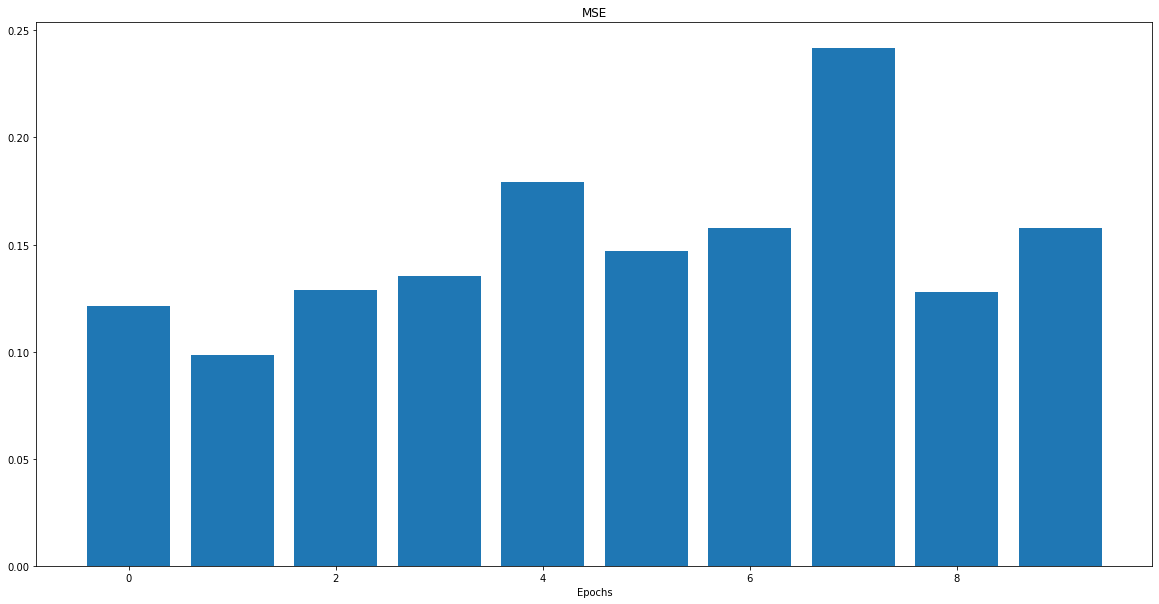

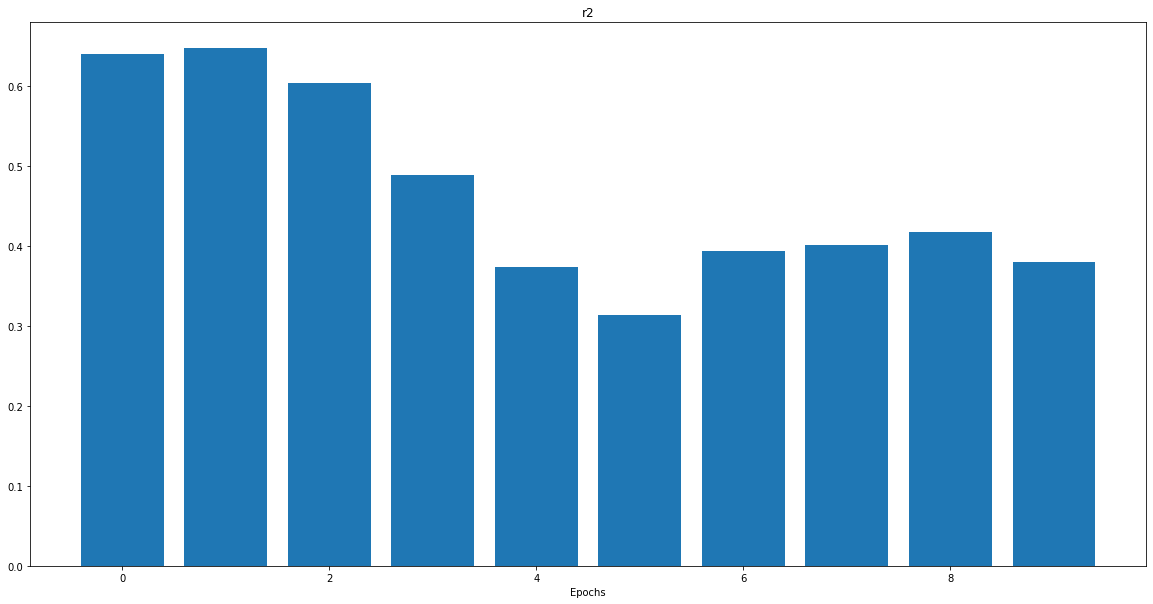

In [33]:
# Valance Neural Net
kfold = KFold(n_splits=10)
k = 0
r2 = np.empty((1,0),dtype=float)
mse = np.empty((1,0),dtype=float)

for train_index, test_index in kfold.split(all_features_norm):
    k += 1
    print(f'KFold Split: {k}')
    train_X, test_X = all_features_norm.iloc[train_index, :], all_features_norm.iloc[test_index, :]
    train_Y, test_Y = val_y[train_index], val_y[test_index]

    train_dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y))
    test_dataset = tf.data.Dataset.from_tensor_slices((test_X, test_Y))
    SHUFFLE_BUFFER_SIZE = 121

    BATCH_SIZE = 1
    train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
    test_dataset = test_dataset.batch(BATCH_SIZE)

    val_model = keras.Sequential([
        keras.layers.Dense(50, activation='relu'),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(20, activation='relu'),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(1, activation='linear')
    ])

    val_model.compile(
        optimizer=keras.optimizers.RMSprop(),
        loss=keras.losses.MeanSquaredError(),
        metrics=['mse']
    )

    val_model.fit(train_dataset, epochs=10, verbose=0)
    pred = val_model.predict(test_X)
    r2 = np.append(r2,r2_score(test_Y, pred))
    mse = np.append(mse, mean_squared_error(test_Y, pred))
    
print('Valance - 10 fold cross validation')
print('r2:')
print(r2)
print('MSE:')
print(mse)

val_data = {
    'Mean': [
        np.mean(r2),
        np.mean(mse)
    ],
    'Std': [
        np.std(r2),
        np.std(mse)
    ]}
index = ['r2', 'MSE']

epochs = range(len(mse))
plt.figure(figsize=(20,10))
plt.bar(epochs, mse, label='MSE')
plt.xlabel('KFold Split')
plt.title('MSE')

plt.figure(figsize=(20,10))
plt.bar(epochs, r2, label='r2')
plt.xlabel('KFold Split')
plt.title('r2')

val_df = pd.DataFrame(data=val_data, index=index)
val_df

### Neural Net Baseline Metrics

In [34]:
df = pd.concat([aro_df,val_df], axis=1)
df.index = pd.Index(['R square', 'Mean Square Error'])
df.columns = pd.MultiIndex.from_product([['Arousal', 'Valance'],['Mean', 'Std']])

s = df.style
s.set_table_styles([
    {'selector': 'th.col_heading', 'props': 'text-align: center; font-size: 1.2em; font-style: italic; padding: 0 3em;'},
    {'selector': 'th.col_heading.level0', 'props': 'font-style: normal; font-size: 1.5em;'},
    {'selector': 'th.row_heading', 'props': 'text-align: center; font-size: 1.2em; font-style: italic; font-weight: bold;'},
    {'selector': 'td', 'props': 'text-align: center;'},
], overwrite=False)

# Support Vector Regression with lesser feature input
Remove features to support features available in Meyda js\
meyda_available_features = ['rms','zcr','spectralRolloff','spectralCentroid','spectralSpread','spectralSkewness','spectralKurtosis','spectralFlatness','mfcc','chroma','loudness','energy','perceptualSharpness','spectralSlope']

# Neural Net with lesser feature input

In [31]:
# Build Arousal model

aro_model = keras.Sequential([
    keras.layers.Conv1D(filters=32, kernel_size=10, strides=1, activation='relu', kernel_initializer='glorot_uniform', input_shape=(74, 1)),
    keras.layers.MaxPool1D(2),
    keras.layers.Dropout(0.5),
    keras.layers.Conv1D(filters=32, kernel_size=8, activation='relu', kernel_initializer='glorot_uniform'),
    keras.layers.MaxPool1D(2),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(256, kernel_initializer='glorot_uniform', activation='relu'),
    keras.layers.Dense(1, kernel_initializer='glorot_uniform', activation='linear')
])

aro_model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=0.001, rho=0.000001),
    loss=keras.losses.MeanSquaredError(),
    metrics=keras.metrics.MeanSquaredError())

In [24]:
aro_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 65, 32)            352       
                                                                 
 dropout_4 (Dropout)         (None, 65, 32)            0         
                                                                 
 conv1d_5 (Conv1D)           (None, 58, 32)            8224      
                                                                 
 dropout_5 (Dropout)         (None, 58, 32)            0         
                                                                 
 dense_4 (Dense)             (None, 58, 256)           8448      
                                                                 
 dense_5 (Dense)             (None, 58, 1)             257       
                                                                 
Total params: 17,281
Trainable params: 17,281
Non-trai

In [25]:
history = aro_model.fit(
    f_features_norm,
    aro_y,
    epochs=100,
    batch_size=1213,
    validation_split=0.1,
    shuffle=True)

Epoch 1/100
1/1 [==============================] - 1s 1s/step - loss: 0.3314 - mean_squared_error: 0.3314 - val_loss: 0.3571 - val_mean_squared_error: 0.3571
Epoch 2/100
1/1 [==============================] - 0s 263ms/step - loss: 0.3309 - mean_squared_error: 0.3309 - val_loss: 0.3680 - val_mean_squared_error: 0.3680
Epoch 3/100
1/1 [==============================] - 0s 268ms/step - loss: 0.3310 - mean_squared_error: 0.3310 - val_loss: 0.3571 - val_mean_squared_error: 0.3571
Epoch 4/100
1/1 [==============================] - 0s 268ms/step - loss: 0.3307 - mean_squared_error: 0.3307 - val_loss: 0.3674 - val_mean_squared_error: 0.3674
Epoch 5/100
1/1 [==============================] - 0s 256ms/step - loss: 0.3303 - mean_squared_error: 0.3303 - val_loss: 0.3571 - val_mean_squared_error: 0.3571
Epoch 6/100
1/1 [==============================] - 0s 274ms/step - loss: 0.3305 - mean_squared_error: 0.3305 - val_loss: 0.3671 - val_mean_squared_error: 0.3671
Epoch 7/100
1/1 [====================